# Create a 1D signal LSTM based LSGAN for voice recorded signals
## Use a very basic GAN architecture that works with a single dimension (1D array)

In [1]:
import sounddevice as sd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Audio
from scipy.io.wavfile import write
import os
import torch.nn.functional as F


# Lets setup some basic configurations

In [2]:
sample_rate = 48000
duration = 1 # second
signal_length = sample_rate * duration

In [3]:
import random
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)    

seed_everything(42)

## Define the Generator class

In [4]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=128, output_dim=1024, num_layers=2):
        super(Generator, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z):
        # z shape: (batch_size, seq_length, input_dim)
        z = z.unsqueeze(1)  # Add sequence length dimension
        out, _ = self.rnn(z)  # RNN output
        out = self.fc(out[:, -1, :])  # Get the last time step output
        return torch.tanh(out)  # Normalize output to [-1, 1]

## Define the Discriminator class

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=128, num_layers=2):
        super(Discriminator, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_dim)
        x = x.unsqueeze(1)  # Add sequence length dimension
        out, _ = self.rnn(x)  # RNN output
        out = self.fc(out[:, -1, :])  # Get the last time step output
        return torch.sigmoid(out)  # Output probability

## Custom dataset class for voice signals

In [6]:
class AudioDataset(Dataset):
    def __init__(self, data_dir, sample_rate=22050, duration=2):
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.duration = duration
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]  # Only .npy files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        # Load numpy array
        waveform = np.load(file_path)
        # Ensure the audio is 2 seconds long
        target_length = self.sample_rate * self.duration
        if waveform.size < target_length:
            # Pad the waveform if it's shorter than 2 seconds
            waveform = np.pad(waveform, (0, target_length - waveform.size), mode='constant')
        else:
            # Trim the waveform if it's longer than duration
            waveform = waveform[:target_length]
        waveform = waveform.astype(np.float32)
        waveform = (waveform - min(waveform)) / (max(waveform) - min(waveform)) * 2 - 1 
        waveform = waveform/np.max(waveform)
        return torch.tensor(waveform,dtype=torch.float32)  # Convert to tensor


## Prepare the dataset for training the GAN

In [7]:
# Create the dataset and dataloader
batch_size = 128
dataset = AudioDataset('audioMNIST/', sample_rate, duration)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(len(dataset))

30000


tensor([-0.0995, -0.0995, -0.1014,  ..., -0.0686, -0.0686, -0.0686])


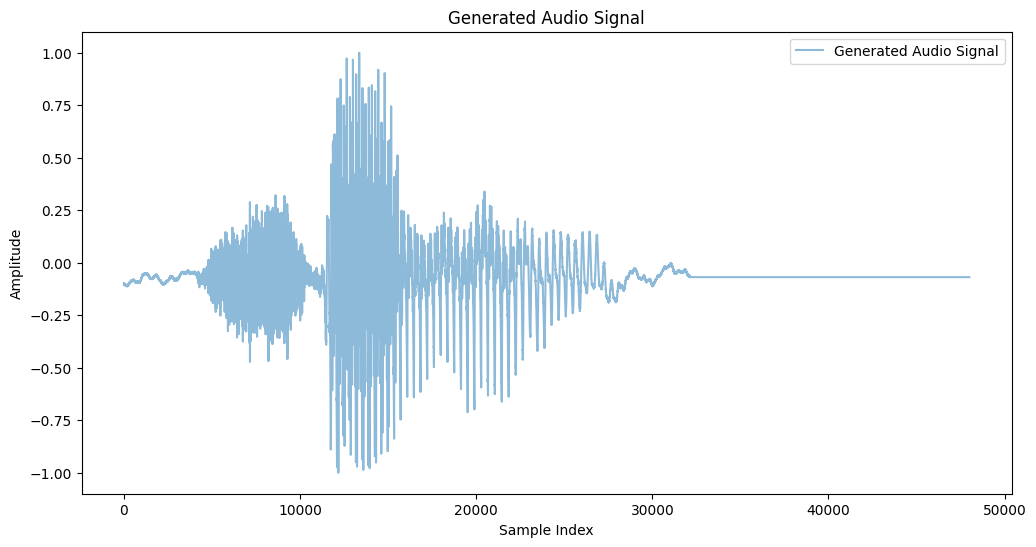

In [8]:
# plot the signal 
for batch in dataloader:
    # Plot the generated audio signal
    plt.figure(figsize=(12, 6))
    print(batch[0])
    plt.plot(batch[0], label='Generated Audio Signal', alpha=0.5)
    plt.title('Generated Audio Signal')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
    break

## Initialize the generator and discriminator

In [9]:
# Set up the GAN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyperparameters
latent_dim = 128
lr = 0.0005
# Initialize generator and discriminator
generator = Generator(input_dim=latent_dim, hidden_dim=64, output_dim=signal_length, num_layers=8)
discriminator = Discriminator(input_dim=signal_length, hidden_dim=latent_dim, num_layers=1)

## Define the loss function and optimizers

In [10]:
criterion = nn.BCELoss()
g_optimizer = torch.optim.SGD(generator.parameters(), lr=lr, momentum=0.9)
d_optimizer = torch.optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9)
num_epochs = 100

In [11]:
def lsgan_discriminator_loss(real_samples, fake_samples):
    d_loss = 0.5 * ((real_samples - 1) ** 2).mean() + 0.5 * (fake_samples ** 2).mean()
    return d_loss

def lsgan_generator_loss(fake_samples):
    g_loss = 0.5 * (fake_samples - 1) ** 2  
    return g_loss.mean()

## Training the GAN

In [12]:
# Lists to store losses
weight_clipping_limit = 0.01  # Weight clipping limit

g_losses = []
d_losses = []
# Training loop
for epoch in range(num_epochs):
    for real_samples in dataloader: # batch is (batch_size, time_steps, features)
        # Train the discriminator
        # Generate fake signal
        z =  (-2.0)*(torch.randn(real_samples.size(0), latent_dim))-1.0
        fake_samples = generator(z)
        real_samples = real_samples
        
        real_output = discriminator(real_samples)
        fake_output = discriminator(fake_samples)

        d_loss = lsgan_discriminator_loss(real_output,fake_output)
        
        discriminator.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train the generator
        z =  (-2.0)*(torch.randn(real_samples.size(0), latent_dim))-1.0
        
        fake_samples = generator(z)
        fake_output = discriminator(fake_samples.detach())
        g_loss = lsgan_generator_loss(fake_output)
        
        generator.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Store losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
    #if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}')

Epoch: 0, Generator Loss: 0.13531140983104706, Discriminator Loss: 0.2348453402519226
Epoch: 0, Generator Loss: 0.1354234367609024, Discriminator Loss: 0.23631086945533752
Epoch: 0, Generator Loss: 0.1355825811624527, Discriminator Loss: 0.23505079746246338
Epoch: 0, Generator Loss: 0.13578486442565918, Discriminator Loss: 0.23740561306476593
Epoch: 0, Generator Loss: 0.13602572679519653, Discriminator Loss: 0.2361118197441101
Epoch: 0, Generator Loss: 0.13630126416683197, Discriminator Loss: 0.23936831951141357
Epoch: 0, Generator Loss: 0.13660871982574463, Discriminator Loss: 0.23235172033309937
Epoch: 0, Generator Loss: 0.13694387674331665, Discriminator Loss: 0.23657408356666565
Epoch: 0, Generator Loss: 0.13730517029762268, Discriminator Loss: 0.23768043518066406
Epoch: 0, Generator Loss: 0.13768967986106873, Discriminator Loss: 0.23421737551689148
Epoch: 0, Generator Loss: 0.138094961643219, Discriminator Loss: 0.23578350245952606
Epoch: 0, Generator Loss: 0.1385190337896347, Dis

KeyboardInterrupt: 

## Plot the losses

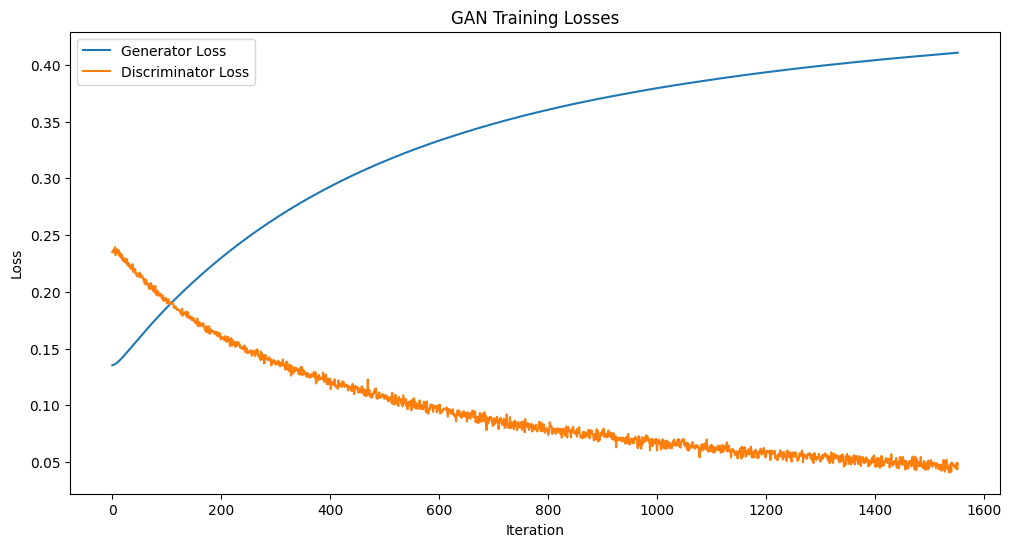

In [13]:
# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.title('GAN Training Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()        
        

## Generate new signals after training

In [ ]:
# Set the generator to evaluation mode
generator.eval()
# Generate and visualize a sample output
with torch.no_grad():
    z =  torch.tanh(torch.randn(1, latent_dim))
    generated_audio = generator(z).detach().numpy().flatten()
print(generated_audio.shape)
# Plot the generated audio signal
plt.figure(figsize=(12, 6))
plt.plot(generated_audio, label='Generated Audio Signal', alpha=0.5)
plt.title('Generated Audio Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# saving the output
np.save('generated/generated.npy', generated_audio)
from scipy.io.wavfile import write

# Assuming the array values are in the range of int16 for WAV format
# Scale the array if necessary
generated_audio = np.int16(generated_audio / np.max(np.abs(generated_audio)) * 32767)

# Save the array as a WAV file
write('generated/generated.wav', sample_rate, generated_audio) 